<a href="https://colab.research.google.com/github/lrsilsbee/Machine-Learning/blob/main/Lauren_Silsbee_assumptions_of_linear_regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the houseprices data from Thinkful's database.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()

Reimplement the model you built in the previous checkpoint.

In [ ]:
#create dummies first
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.centralair, prefix="centralair", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(houseprices_df.centralair, prefix="centralair", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.street, prefix="street", drop_first=True).columns)
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,centralair_Y,street_Pave
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,1,1
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,1,1
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,1,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,1,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,1,1


In [ ]:
Y = houseprices_df['saleprice']
X = houseprices_df[['garagecars', 'grlivarea', 'overallqual'] + dummy_column_names]
lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

predictions = lrm.predict(X)
errors = Y - predictions
print(lrm.coef_)
print(lrm.intercept_)

[20601.09423667    51.62327099 26348.98191142 15875.23261034
  -716.3524618 ]
-108556.25969422012


Assumption: The error term should be zero on average

In [ ]:
predictions = lrm.predict(X)
errors = Y - predictions
print("Mean of the errors is: {}".format(np.mean(errors)))

Mean of the errors is: -1.0943837616949865e-11


The mean of the errors is close enough to 1 that this assumption is satisfied.

Assumption: Homoscedasticity

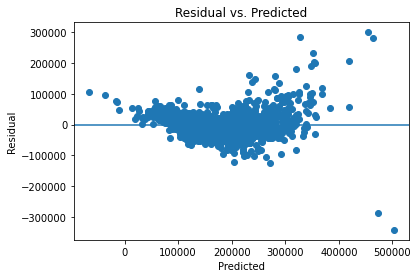

In [ ]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

print(bartlett(predictions, errors))
print(levene(predictions, errors))

BartlettResult(statistic=386.6131230463734, pvalue=4.520772188115233e-86)
LeveneResult(statistic=412.55475762432377, pvalue=6.754276653153839e-86)


The above plot shows a pattern and the Bartlett and Levene Results show us that we cannot reject the null of homoscedasticity. This indicates that there is a heteroscedasticity problem.

Assumption: Low multicollinearity

In [ ]:
X.corr()

,garagecars,grlivarea,overallqual,centralair_Y,street_Pave
garagecars,1.000000,0.467247,0.600671,0.233726,-0.020025
grlivarea,0.467247,1.000000,0.593007,0.093666,0.044121
overallqual,0.600671,0.593007,1.000000,0.272038,0.058823
centralair_Y,0.233726,0.093666,0.272038,1.000000,0.069869
street_Pave,-0.020025,0.044121,0.058823,0.069869,1.000000


The correlation matrix indicates that some explanatory variables are correlated with each other. Garage/living area and garagecars are correlated (.467), overall quality and garage/living area are correlated (.593), and overall quality and garage cars are correlated (.601). This will have to be addressed, perhaps by removing some of these variables.

Assumption: Error terms should be uncorrelated with one another

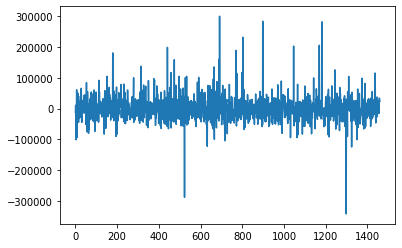

In [ ]:
plt.plot(errors)
plt.show()

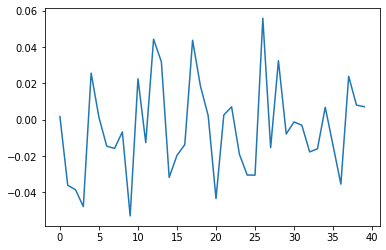

In [ ]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)
plt.plot(acf_data[1:])
plt.show()

The above visualizations indicate that the error terms are not correlated with one another. The autocorrelation between the errors is only between -.05 and .06.

Assumption: Explanatory variables and error terms should be independent

In [ ]:
print(houseprices_df['garagecars'].corr(errors))
print(houseprices_df['grlivarea'].corr(errors))
print(houseprices_df['overallqual'].corr(errors))
print(houseprices_df['centralair_Y'].corr(errors))
print(houseprices_df['street_Pave'].corr(errors))

3.296238206809174e-16
2.8474552548242987e-16
-6.996111531345448e-16
-1.8207029107593874e-16
-2.118882581541319e-16


The error terms are not correlated.